# Introdução
Este projeto analisa os dados de uma campanha de marketing de um banco, 
identificando padrões que ajudam a entender quais clientes têm maior chance 
de aceitar a oferta do produto.

### Tecnologias usadas:
- **Python** (pandas, matplotlib, seaborn)
- **SQLite** (consultas SQL diretas no DataFrame)


1. Carregamento e preparação dos dados

In [35]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


df = pd.read_csv('https://raw.githubusercontent.com/Lincoln-M-Oliveira/analise-banco/refs/heads/main/bank.csv',
     sep=';', encoding='utf-8')

# Visualizar primeiras linhas
df.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,Unnamed: 17
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no,NaN
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no,NaN
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no,NaN
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no,NaN
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no,NaN


In [36]:
# Transformar colunas categóricas yes/no para 1/0
for col in ['default', 'housing', 'loan', 'y']:
    df[col] = df[col].map({'yes':1 ,'no':0 ,'1':1, '0':0})

# Conectar o SQLite
conn = sqlite3.connect('bank_marketing.db')
df.to_sql('bank', conn, if_exists='replace', index=False)

print(f"Tabela 'bank' criada com {len(df)} registros")

Tabela 'bank' criada com 4521 registros


## 2. Função auxiliar para consultas

In [37]:
def run_query(query):
    return pd.read_sql_query(query, conn)

## 3. Análises dos dados

### 3.1 Distribuição por profissão



<function matplotlib.pyplot.show(close=None, block=None)>

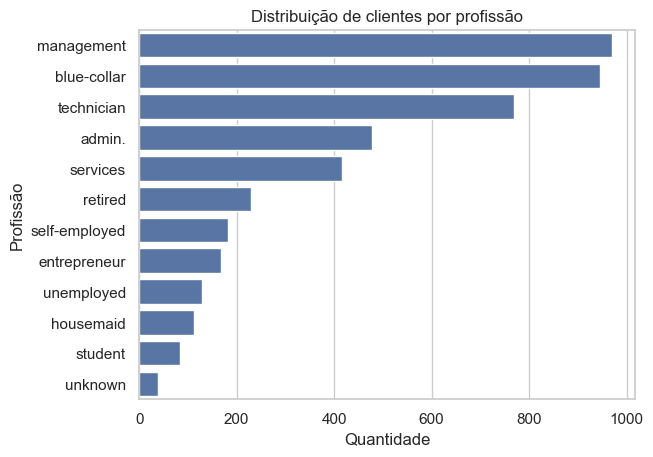

In [38]:

q1 = run_query("""
SELECT job, COUNT(*) AS total
FROM bank
GROUP BY job
ORDER BY total DESC;
""")

plt.Figure(figsize=(10,5))
sns.barplot(x='total', y='job', data=q1)
plt.title('Distribuição de clientes por profissão')
plt.xlabel('Quantidade')
plt.ylabel('Profissão')
plt.savefig('imagens/distribuicao_profissao.png', bbox_inches='tight')
plt.show

## 3.2 Média de saldo por estado civil

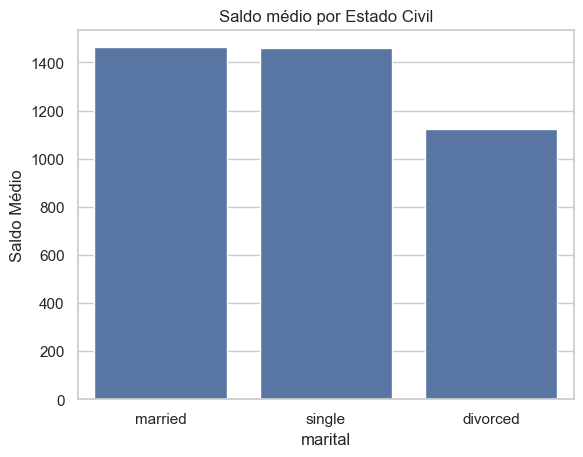

In [39]:
q2 = run_query("""
SELECT marital, AVG(balance) AS media_saldo
FROM bank
GROUP BY marital
ORDER BY media_saldo DESC;
""")

sns.barplot(x='marital', y='media_saldo', data=q2)
plt.title('Saldo médio por Estado Civil')
plt.ylabel('Saldo Médio')
plt.savefig('imagens/saldo_medio.png', bbox_inches='tight')
plt.show()

## 3.3 Taxa de Sucesso por Profissão

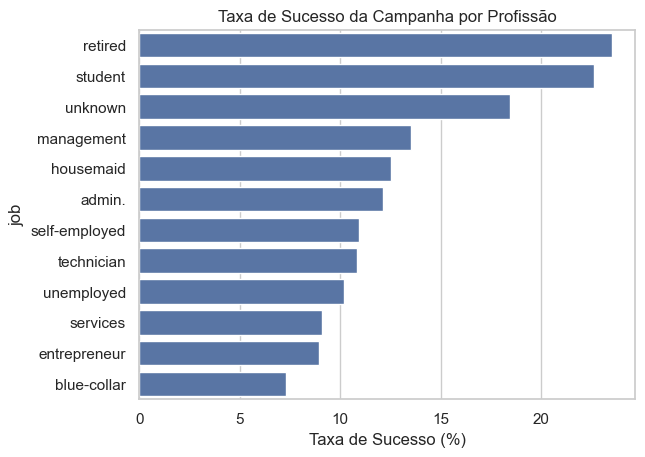

In [40]:
q3 = run_query("""
    SELECT job,
            SUM(y) AS conversoes,
            COUNT(*) AS total,
            ROUND(100.0 * SUM(y) / COUNT(*), 2) AS taxa_sucesso
    FROM bank
    GROUP BY job
    ORDER BY taxa_sucesso DESC;
""")

sns.barplot(x='taxa_sucesso', y='job', data=q3)
plt.title('Taxa de Sucesso da Campanha por Profissão')
plt.xlabel('Taxa de Sucesso (%)')
plt.savefig('imagens/sucesso_profissao.png', bbox_inches='tight')
plt.show()

## 3.4 Taxa de Sucesso por Faixa Etária

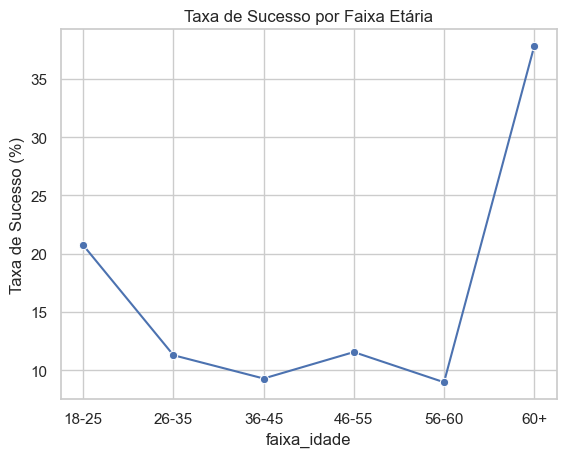

In [41]:
q4 = run_query("""
SELECT 
    CASE
        WHEN age BETWEEN 18 AND 25 THEN '18-25'
        WHEN age BETWEEN 26 AND 35 THEN '26-35'
        WHEN age BETWEEN 36 AND 45 THEN '36-45'
        WHEN age BETWEEN 46 AND 55 THEN '46-55'
        WHEN age BETWEEN 56 AND 60 THEN '56-60'
        ELSE '60+'
    END AS faixa_idade,
    ROUND(AVG(y) * 100, 2) AS taxa_sucesso
FROM bank
GROUP BY faixa_idade
ORDER BY faixa_idade;
""")

sns.lineplot(x='faixa_idade', y='taxa_sucesso', data=q4, marker='o')
plt.title('Taxa de Sucesso por Faixa Etária')
plt.ylabel('Taxa de Sucesso (%)')
plt.savefig('imagens/sucesso_idade.png', bbox_inches='tight')
plt.show()


# Conclusões

- Profissões como **aposentados** e **estudantes** apresentaram taxas de conversão acima da média.
- Clientes entre **26 e 35 anos** tiveram desempenho melhor que outras faixas etárias.
- Estado civil "solteiro" tende a ter maior saldo médio no banco.

Essas informações podem direcionar estratégias de marketing mais eficazes, reduzindo custo e aumentando conversões.